# Setup
(optional) Create an enviroment using the enviroment.yaml file using
```
conda env create --file environment.yaml
```
This is optional, since the notebook uses standard packages such as `pandas` and `numpy`.


In [11]:
# import python libraries
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import scipy.stats
from fitter import Fitter, get_common_distributions, get_distributions

# import files from the same directory
from game import game
from markov_chain_game import MarkovChainGame

# Section 1: Monte Carlo Method

This section runs the game class from the `game.py` file for a varying number of trails. The only difference between the trials is the variance of the output, so feel free to skip the runs with more trials, since the results are similar.

It then attempts to approximate the distribution generated from the Monte-Carlo runs using common discrete distributions, such as the geometric distribution

In [4]:
def run_sim(trials = 10000, run_seed = 12345678, x_bins=100):
    cycles = []
    for i in range(trials):
        cycles.append(game())

    results = pd.DataFrame(cycles, columns=["cycles", "winner"])
    results.to_csv("t"+str(trials)+"_s"+str(run_seed)+"results.csv", index=False)
    results.head(5)
    results_grouped = results.groupby("cycles", as_index=False).count()
    results_grouped.columns = ["cycles", "count"]
    results_grouped.head(5)
    fig, axes = plt.subplots(figsize=(10, 5))
    axes.bar(results_grouped["cycles"], height=results_grouped["count"])
    plt.title('Output with '+ str(trials) + ' Trials')
    plt.xlabel('cycles')
    plt.ylabel('values')
    
    # Show graph
    plt.show()
    expected_cycles = results["cycles"].mean()
    print("Expected number of cycles for " + str(trials)+" trials : ", expected_cycles)   
    f = Fitter(results["cycles"].values,
           distributions= get_common_distributions(), bins=x_bins)
    f.fit()
    
    return results, results_grouped, f

## Simulate 10,000 runs

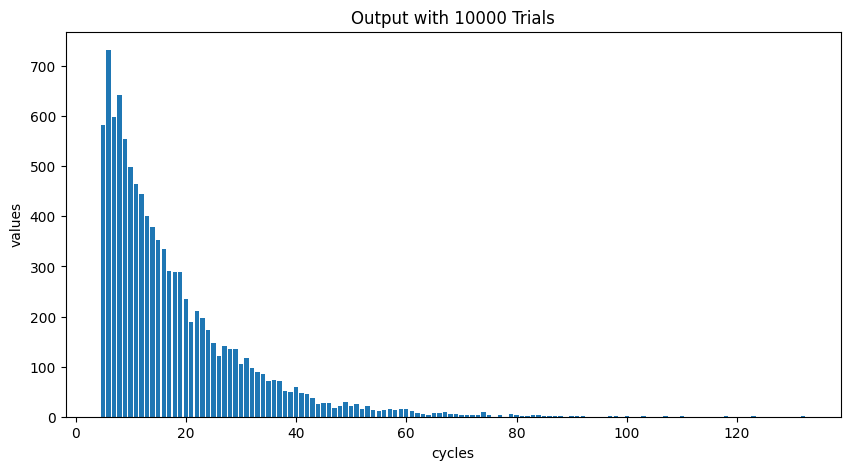

Expected number of cycles for 10000 trials :  17.591


Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 12.64it/s]


In [5]:
results, results_grouped, f = run_sim( trials=10000, run_seed=12345678)


## Fitting Discrete Distributions

### Fitting Poisson

  params: FitParams(mu=17.569013284025036, loc=0.0)
 success: True
 message: 'Optimization terminated successfully.'


<Axes: title={'center': 'Fitted $\\tt poisson$ PMF and Histogram'}, xlabel='k', ylabel='PMF'>

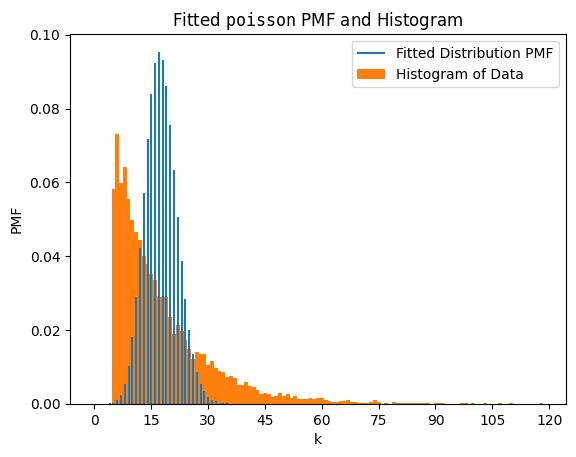

In [6]:
res = scipy.stats.fit(scipy.stats.poisson, results[results["cycles"]<120]["cycles"],[(1,120)])
print(res)
res.plot()

### Binomial

  params: FitParams(n=494.0, p=0.03556480025623285, loc=0.0)
 success: True
 message: 'Optimization terminated successfully.'


<Axes: title={'center': 'Fitted $\\tt binom$ PMF and Histogram'}, xlabel='k', ylabel='PMF'>

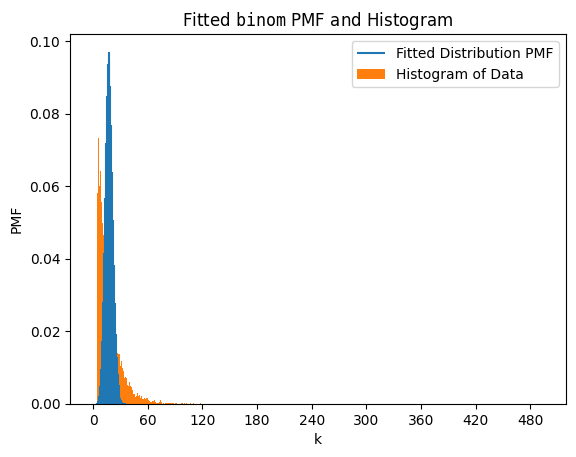

In [7]:
res = scipy.stats.fit(scipy.stats.binom, results[results["cycles"]<120]["cycles"],bounds = [(1,500),(0,1)])
print(res)
res.plot()

### Fitting Geometric

  params: FitParams(p=0.07378568942141023, loc=4.0)
 success: True
 message: 'Optimization terminated successfully.'


<Axes: title={'center': 'Fitted $\\tt geom$ PMF and Histogram'}, xlabel='k', ylabel='PMF'>

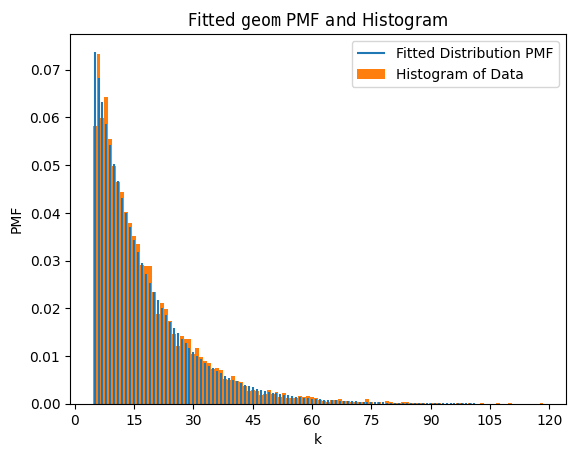

In [8]:
res = scipy.stats.fit(scipy.stats.geom, results[results["cycles"]<120]["cycles"],bounds = [(0,1),(0,10)])
print(res)
res.plot()

#### Find mean, Variance, Skewness and kurtosis

In [27]:
results[results["cycles"]<120]["cycles"].min(), results[results["cycles"]<120]["cycles"].max()
mean, var, skew, kurt = scipy.stats.geom.stats(0.08044530074000428, moments='mvsk')
mean, var, skew, kurt

(5, 108)

(12.43080690607344, 142.09415343000967, 2.0017586236188807, 6.007037587232556)

### Fit negative binomial

  params: FitParams(n=3.0, p=0.14782316158243558, loc=0.0)
 success: True
 message: 'Optimization terminated successfully.'


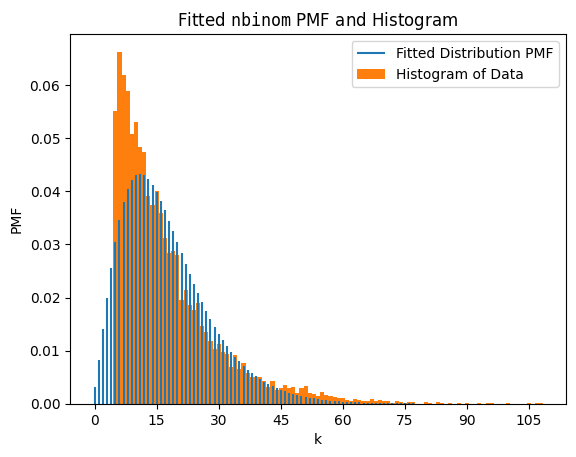

In [28]:
# scipy.stats.rv_discrete
res = scipy.stats.fit(dist=scipy.stats.nbinom, data=results[results["cycles"]<120]["cycles"], bounds=[(1,100),(0,1)])
print(res)
res.plot()

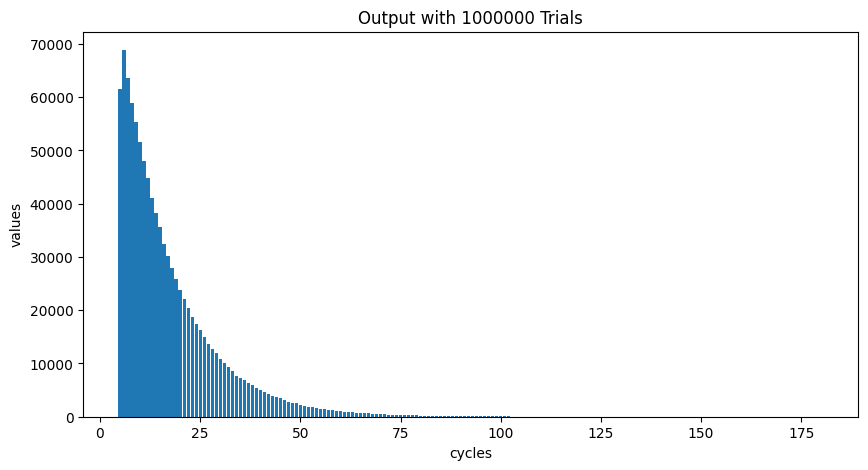

Expected number of cycles for 1000000 trials :  17.549173


Fitting 10 distributions:  80%|████████  | 8/10 [00:25<00:09,  4.73s/it]SKIPPED exponpow distribution (taking more than 30 seconds)
SKIPPED lognorm distribution (taking more than 30 seconds)
Fitting 10 distributions: 100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


In [29]:
results, results_grouped, f = run_sim( trials=1000000, run_seed=12345678, x_bins=100)
# f.summary()

### Fit Geometric

  params: FitParams(p=0.07388920160176778, loc=4.0)
 success: True
 message: 'Optimization terminated successfully.'


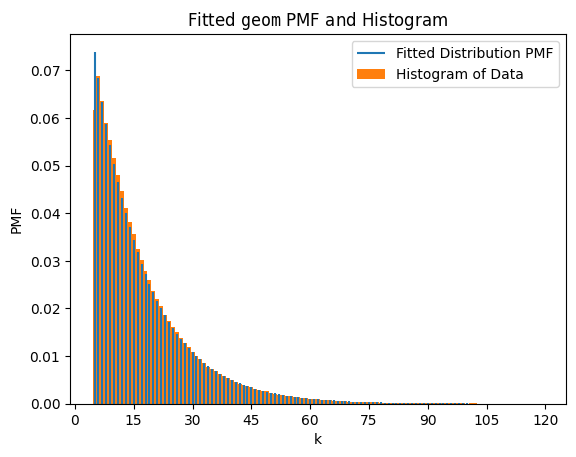

In [30]:
res = scipy.stats.fit(scipy.stats.geom, results[results["cycles"]<120]["cycles"],bounds = [(0,1),(0,10)])
print(res)
res.plot()

## Simulate 10,000,000 Trials

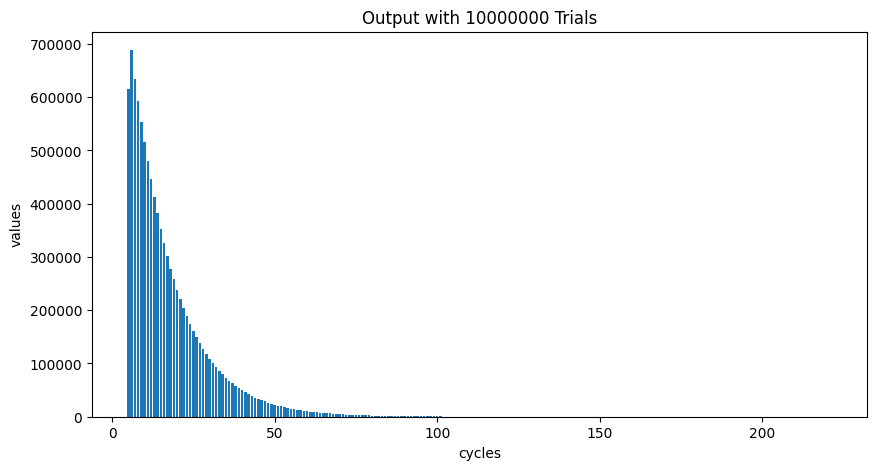

Expected number of cycles for 10000000 trials :  17.5343523


Fitting 10 distributions:  50%|█████     | 5/10 [00:30<00:40,  8.07s/it]SKIPPED chi2 distribution (taking more than 30 seconds)
SKIPPED exponpow distribution (taking more than 30 seconds)
SKIPPED lognorm distribution (taking more than 30 seconds)
SKIPPED gamma distribution (taking more than 30 seconds)
SKIPPED powerlaw distribution (taking more than 30 seconds)
Fitting 10 distributions: 100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


In [31]:
results, results_grouped, f= run_sim( trials=10000000, run_seed=12345678)
# f.summary()

### Fit Geometric Distribution

  params: FitParams(p=0.07369732360826195, loc=4.0)
 success: True
 message: 'Optimization terminated successfully.'


<Axes: title={'center': 'Fitted $\\tt geom$ PMF and Histogram'}, xlabel='k', ylabel='PMF'>

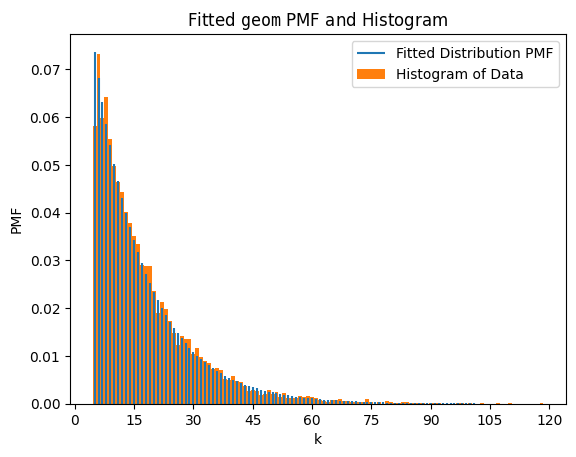

In [9]:
res = scipy.stats.fit(scipy.stats.geom, results[results["cycles"]<120]["cycles"],bounds = [(0,1),(0,10)])
print(res)
res.plot()

# Section 2: Markov Chain Implementation
The exact distribution is obtained by modelling the game as a Markov Chain. The chain is implemented in the `markov_chain_game.py` file. 

## Run Markov Chain
We compute probabilities for the game terminating upto 100 cycles using the `compute_probabilities()` function in `markov_chain_game.py`

In [10]:
chain = MarkovChainGame(A_start=4, B_start=4, pot=2)
simulation = chain.compute_probabilities(100)
simulation.round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.062, 0.069, 0.064, 0.059,
       0.055, 0.052, 0.048, 0.044, 0.041, 0.038, 0.035, 0.033, 0.03 ,
       0.028, 0.026, 0.024, 0.022, 0.02 , 0.019, 0.017, 0.016, 0.015,
       0.014, 0.013, 0.012, 0.011, 0.01 , 0.009, 0.009, 0.008, 0.007,
       0.007, 0.006, 0.006, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004,
       0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ])

## Plot probabilities

<BarContainer object of 101 artists>

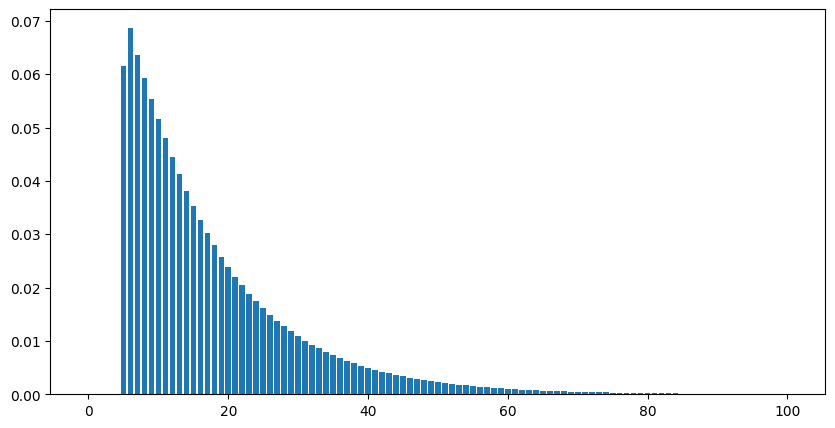

In [34]:
fig, axes = plt.subplots(figsize=(10, 5))
axes.bar(np.arange(len(simulation) ), height=simulation)
plt.show()

The exact distribution is obtained from the markov chain, which looks like a smoother version of the the distribution obtained from the monte carlo simulations

## Goodness of fir Chi-Square test

In [60]:
trials = 10000000
results_grouped["pct"] = results_grouped["count"]/trials

res1 = results_grouped[results_grouped["cycles"] < 101]["pct"]
# res1
res2 = pd.concat([res1, pd.DataFrame(simulation[5:])], axis=1)
res2.columns = ['obs', 'exp']
res2['sq_e'] = ((res2['obs'] - res2['exp'])**2)/res2['exp']
# res2['diff'] = res2['obs'] - res2['exp']
# res2['sq']=res2['diff']**2
# res2['sq_e']=res2['sq']/res2['exp']
# res1['simulation']=pd.DataFrame(simulation[5:])
# res2
# res2.shape
print('Chi-Square metrics', res2["sq_e"].sum())

Chi-Square metrics 8.53573564819846e-06


$\chi_0^2 = 8.53573564819846e-06$ is much less than $\chi_{0.025,94}^2$